In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Thu Jan 11 22:06:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    13W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-15/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


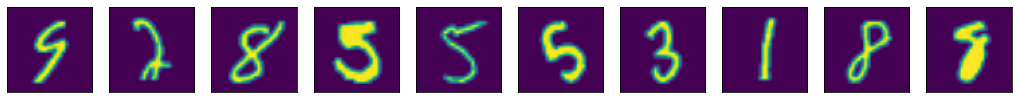

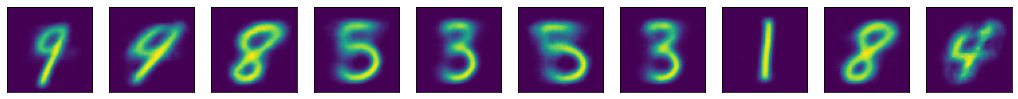

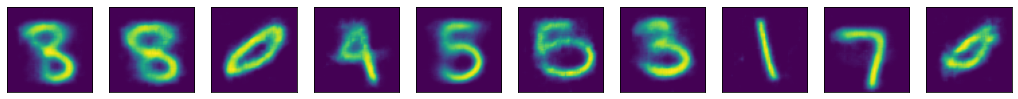

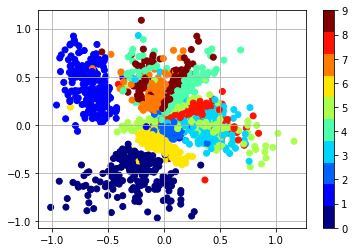

17001
lse_loss 0.0001431734417565167
recon_loss 0.104660265147686
17002
lse_loss 0.00012044003960909322
recon_loss 0.11133363842964172
17003
lse_loss 0.00012053610407747328
recon_loss 0.10121701657772064
17004
lse_loss 0.0001333439431618899
recon_loss 0.11115586757659912
17005
lse_loss 0.00011338412878103554
recon_loss 0.11451487243175507
17006
lse_loss 0.0001280004798900336
recon_loss 0.09583480656147003
17007
lse_loss 0.00013486343959812075
recon_loss 0.09917451441287994
17008
lse_loss 0.0001374387793475762
recon_loss 0.10074363648891449
17009
lse_loss 0.00013905076775699854
recon_loss 0.11288505047559738
17010
lse_loss 0.00011757054016925395
recon_loss 0.10378599166870117
17011
lse_loss 0.000122141616884619
recon_loss 0.10598807781934738
17012
lse_loss 0.00011952703061979264
recon_loss 0.10200172662734985
17013
lse_loss 0.0002665148058440536
recon_loss 0.10513129830360413
17014
lse_loss 0.0010486242827028036
recon_loss 0.12377091497182846
17015
lse_loss 0.00014966443995945156
recon_

17121
lse_loss 0.0001179960963781923
recon_loss 0.1000487431883812
17122
lse_loss 0.00011764213559217751
recon_loss 0.10184543579816818
17123
lse_loss 0.00022059326875023544
recon_loss 0.10626333206892014
17124
lse_loss 0.0002494784421287477
recon_loss 0.10774984210729599
17125
lse_loss 0.00015004465240053833
recon_loss 0.10256916284561157
17126
lse_loss 0.0001461903448216617
recon_loss 0.10682736337184906
17127
lse_loss 0.00011880739475600421
recon_loss 0.10411526262760162
17128
lse_loss 0.00012465812324080616
recon_loss 0.0993642508983612
17129
lse_loss 0.00012987788068130612
recon_loss 0.10188660025596619
17130
lse_loss 0.00013016005686949939
recon_loss 0.09983530640602112
17131
lse_loss 0.00014652936079073697
recon_loss 0.11012640595436096
17132
lse_loss 0.00014506556908600032
recon_loss 0.10454434156417847
17133
lse_loss 0.0001330415834672749
recon_loss 0.10349994897842407
17134
lse_loss 0.00015052210073918104
recon_loss 0.09818801283836365
17135
lse_loss 0.00013770689838565886
re

17241
lse_loss 0.00014489798923023045
recon_loss 0.10017450898885727
17242
lse_loss 0.00010699471749830991
recon_loss 0.10723736882209778
17243
lse_loss 0.00014620432921219617
recon_loss 0.10625763982534409
17244
lse_loss 0.00019641060498543084
recon_loss 0.10033562034368515
17245
lse_loss 0.00011971190542681143
recon_loss 0.1007850393652916
17246
lse_loss 0.0001882423966890201
recon_loss 0.10738750547170639
17247
lse_loss 0.00012833610526286066
recon_loss 0.10278265178203583
17248
lse_loss 0.00015274403267540038
recon_loss 0.1082538589835167
17249
lse_loss 0.00013595097698271275
recon_loss 0.1013398990035057
17250
lse_loss 0.00013629179738927633
recon_loss 0.10388603061437607
17251
lse_loss 0.00013755878899246454
recon_loss 0.10232259333133698
17252
lse_loss 0.00013413190026767552
recon_loss 0.10155364125967026
17253
lse_loss 0.00010234079672954977
recon_loss 0.10526230186223984
17254
lse_loss 0.00012166087253717706
recon_loss 0.10047684609889984
17255
lse_loss 0.00012779832468368113


17361
lse_loss 0.00011971083586104214
recon_loss 0.09955714643001556
17362
lse_loss 0.0001255002716789022
recon_loss 0.10121147334575653
17363
lse_loss 0.0001377448352286592
recon_loss 0.10640117526054382
17364
lse_loss 0.00013765148469246924
recon_loss 0.09678274393081665
17365
lse_loss 0.00013328477507457137
recon_loss 0.10774363577365875
17366
lse_loss 0.00013566882989834994
recon_loss 0.09488066285848618
17367
lse_loss 0.00011654404806904495
recon_loss 0.10459842532873154
17368
lse_loss 0.00013761231093667448
recon_loss 0.10922631621360779
17369
lse_loss 0.00042355473851785064
recon_loss 0.09503012895584106
17370
lse_loss 0.00015296964556910098
recon_loss 0.10845275223255157
17371
lse_loss 0.00011597868433455005
recon_loss 0.10318024456501007
17372
lse_loss 0.00012076429993612692
recon_loss 0.10661520808935165
17373
lse_loss 0.0001549119915580377
recon_loss 0.10096266120672226
17374
lse_loss 0.00011211377568542957
recon_loss 0.1063389778137207
17375
lse_loss 0.0001703621237538755
r

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        